In [1]:
!pip install google-cloud-storage google-cloud-bigquery pandas tensorflow numpy
!pip install google-colab google-auth

In [2]:
# 2. 라이브러리 임포트
import os
import io
import numpy as np
import pandas as pd
from google.colab import auth
from google.cloud import storage
from google.cloud import bigquery
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# 3. Google Cloud 인증
auth.authenticate_user()

In [4]:
# @markdown 프로젝트 ID와 버킷 이름을 입력하세요
project_id = "mlopstest-441106" # @param {type:"string"}
bucket_name = "mh_mlopstest" # @param {type:"string"}
assert project_id, "프로젝트 ID를 입력해주세요!"
assert bucket_name, "버킷 이름을 입력해주세요!"

In [5]:
def create_bucket_if_not_exists(bucket_name, project_id):
    """Google Cloud Storage 버킷 생성"""
    storage_client = storage.Client(project=project_id)

    try:
        bucket = storage_client.get_bucket(bucket_name)
        print(f"버킷 {bucket_name}이 이미 존재합니다.")
    except Exception:
        print(f"버킷 {bucket_name}을 생성합니다...")
        bucket = storage_client.create_bucket(bucket_name, location="us")
        print(f"버킷이 생성되었습니다: {bucket.name}")

    return bucket

In [6]:
def upload_image_to_gcs(image_array, bucket, image_path):
    """NumPy 배열을 PNG로 변환하여 GCS에 업로드"""
    img = Image.fromarray(image_array)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    blob = bucket.blob(image_path)
    blob.upload_from_string(img_byte_arr, content_type='image/png')

    return f"gs://{bucket.name}/{image_path}"


In [7]:
# 6. MNIST 데이터 로드 및 GCS 업로드
def process_mnist_data(bucket):
    """MNIST 데이터 처리 및 GCS 업로드"""
    print("MNIST 데이터 로드 중...")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    data_records = []

    # 학습 데이터 처리 (5000개 샘플만 사용)
    print("학습 데이터 처리 및 업로드 중...")
    for i in range(5000):
        if i % 500 == 0:
            print(f"학습 데이터 업로드 중: {i}/5000")

        image_array = x_train[i]
        label = int(y_train[i])
        image_path = f"mnist/train/image_{i}.png"

        # NumPy 배열을 PNG로 변환하여 GCS에 업로드
        image_url = upload_image_to_gcs(image_array, bucket, image_path)

        # data_records에 추가
        data_records.append({
            "image_id": i,
            "label": label,
            "image_url": image_url,
            "dataset_type": "train"
        })

    # 테스트 데이터 처리 (1000개 샘플만 사용)
    print("테스트 데이터 처리 및 업로드 중...")
    for i in range(1000):
        if i % 100 == 0:
            print(f"테스트 데이터 업로드 중: {i}/1000")

        image_array = x_test[i]
        label = int(y_test[i])
        image_path = f"mnist/test/image_{i}.png"

        # NumPy 배열을 PNG로 변환하여 GCS에 업로드
        image_url = upload_image_to_gcs(image_array, bucket, image_path)

        # data_records에 추가
        data_records.append({
            "image_id": i,
            "label": label,
            "image_url": image_url,
            "dataset_type": "test"
        })

    return pd.DataFrame(data_records)


In [8]:
def upload_to_bigquery(df, project_id, dataset_id, table_id):
    """데이터프레임을 BigQuery에 업로드"""
    client = bigquery.Client(project=project_id)

    # BigQuery 데이터셋 참조 객체 생성
    dataset_ref = client.dataset(dataset_id)

    try:
        # 데이터셋 존재 여부 확인
        client.get_dataset(dataset_ref)
        print(f"데이터셋 {dataset_id}이(가) 이미 존재합니다.")
    except Exception:
        # 데이터셋이 존재하지 않을 경우 새로 생성
        print(f"데이터셋 {dataset_id} 생성 중...")
        dataset = bigquery.Dataset(dataset_ref)

        # 데이터셋의 지역을 US로 설정
        dataset.location = 'US'

        # 새로운 데이터셋 생성
        client.create_dataset(dataset)
        print(f"데이터셋 {dataset_id}이(가) 생성되었습니다.")

    # 테이블 스키마 정의
    schema = [
        # 이미지 고유 식별자 (정수형)
        bigquery.SchemaField('image_id', 'INTEGER'),
        # 이미지 레이블/분류 값 (정수형)
        bigquery.SchemaField('label', 'INTEGER'),
        # 이미지 파일의 URL 주소 (문자열)
        bigquery.SchemaField('image_url', 'STRING'),
        # 데이터셋 종류 구분 (예: train, test, validation) (문자열)
        bigquery.SchemaField('dataset_type', 'STRING'),
    ]

    # 생성할 테이블 참조 객체 생성
    table_ref = dataset_ref.table(table_id)

    # 테이블 객체 생성 (정의된 스키마 적용)
    table = bigquery.Table(table_ref, schema=schema)

    # 기존 테이블이 있으면 삭제
    try:
        client.delete_table(table_ref)
        print(f"기존 테이블 {table_id}이(가) 삭제되었습니다.")
    except Exception:
        pass

    # 새 테이블 생성
    print(f"테이블 {table_id} 생성 중...")
    table = client.create_table(table)
    print(f"테이블 {table_id}이(가) 생성되었습니다.")

    # BigQuery에 데이터 업로드 중
    print("BigQuery에 데이터 업로드 중...")
    job_config = bigquery.LoadJobConfig(schema=schema)

    # 데이터 로드 작업 실행
    job = client.load_table_from_dataframe(df, table_ref, job_config=job_config)
    job.result()  # 업로드 완료 대기
    print("업로드 완료!")


In [9]:
def query_and_visualize(project_id, dataset_id, table_id):
    """BigQuery 데이터 쿼리 및 시각화"""
    client = bigquery.Client(project=project_id)

    # 레이블 별 이미지 수 조회
    print("\n레이블 별 이미지 수 분석 중...")
    count_query = f"""
        SELECT label, COUNT(*) as count
        FROM `{project_id}.{dataset_id}.{table_id}`
        GROUP BY label
        ORDER BY label
    """
    counts_df = client.query(count_query).to_dataframe()

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.bar(counts_df['label'], counts_df['count'])
    plt.title('Number of Images per Label')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

    # 샘플 URL 출력
    print("\n각 레이블의 샘플 이미지 URL:")
    sample_query = f"""
        SELECT DISTINCT label,
               ARRAY_AGG(image_url LIMIT 1)[OFFSET(0)] as sample_url,
               COUNT(*) as count
        FROM `{project_id}.{dataset_id}.{table_id}`
        GROUP BY label
        ORDER BY label
    """
    samples_df = client.query(sample_query).to_dataframe()
    return samples_df

In [10]:
# GCS 버킷 생성
bucket = create_bucket_if_not_exists(bucket_name, project_id)

버킷 mh_mlopstest을 생성합니다...
버킷이 생성되었습니다: mh_mlopstest


In [11]:
# MNIST 데이터 처리 및 GCS 업로드
mnist_df = process_mnist_data(bucket)

MNIST 데이터 로드 중...
학습 데이터 처리 및 업로드 중...
학습 데이터 업로드 중: 0/5000
학습 데이터 업로드 중: 500/5000
학습 데이터 업로드 중: 1000/5000
학습 데이터 업로드 중: 1500/5000
학습 데이터 업로드 중: 2000/5000
학습 데이터 업로드 중: 2500/5000
학습 데이터 업로드 중: 3000/5000
학습 데이터 업로드 중: 3500/5000
학습 데이터 업로드 중: 4000/5000
학습 데이터 업로드 중: 4500/5000
테스트 데이터 처리 및 업로드 중...
테스트 데이터 업로드 중: 0/1000
테스트 데이터 업로드 중: 100/1000
테스트 데이터 업로드 중: 200/1000
테스트 데이터 업로드 중: 300/1000
테스트 데이터 업로드 중: 400/1000
테스트 데이터 업로드 중: 500/1000
테스트 데이터 업로드 중: 600/1000
테스트 데이터 업로드 중: 700/1000
테스트 데이터 업로드 중: 800/1000
테스트 데이터 업로드 중: 900/1000


In [12]:
# BigQuery에 메타데이터 업로드
dataset_id = 'mnist_dataset'
table_id = 'mnist_images_gcs'
upload_to_bigquery(mnist_df, project_id, dataset_id, table_id)

데이터셋 mnist_dataset이(가) 이미 존재합니다.
기존 테이블 mnist_images_gcs이(가) 삭제되었습니다.
테이블 mnist_images_gcs 생성 중...
테이블 mnist_images_gcs이(가) 생성되었습니다.
BigQuery에 데이터 업로드 중...
업로드 완료!



레이블 별 이미지 수 분석 중...


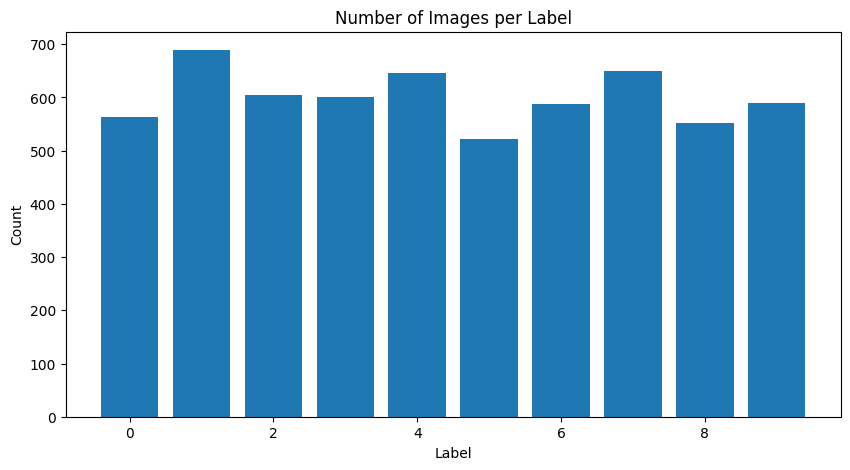


각 레이블의 샘플 이미지 URL:

각 레이블별 샘플 이미지 정보:
   label                                 sample_url  count
0      0   gs://mh_mlopstest/mnist/test/image_3.png    564
1      1   gs://mh_mlopstest/mnist/test/image_2.png    689
2      2   gs://mh_mlopstest/mnist/test/image_1.png    604
3      3  gs://mh_mlopstest/mnist/test/image_18.png    600
4      4   gs://mh_mlopstest/mnist/test/image_4.png    645
5      5   gs://mh_mlopstest/mnist/test/image_8.png    521
6      6  gs://mh_mlopstest/mnist/test/image_11.png    588
7      7   gs://mh_mlopstest/mnist/test/image_0.png    649
8      8  gs://mh_mlopstest/mnist/test/image_61.png    551
9      9   gs://mh_mlopstest/mnist/test/image_7.png    589


In [13]:
# 데이터 분석 및 시각화
samples_df = query_and_visualize(project_id, dataset_id, table_id)
print("\n각 레이블별 샘플 이미지 정보:")
print(samples_df)

In [14]:
# 특정 레이블의 이미지 URL 조회
query = f'''
    SELECT image_url
    FROM `{project_id}.{dataset_id}.{table_id}`
    WHERE label = 5
    LIMIT 5
'''
client = bigquery.Client(project=project_id)
df = client.query(query).to_dataframe()
print("숫자 5의 이미지 URL 샘플:")
print(df)

숫자 5의 이미지 URL 샘플:
                                   image_url
0   gs://mh_mlopstest/mnist/test/image_8.png
1  gs://mh_mlopstest/mnist/test/image_15.png
2  gs://mh_mlopstest/mnist/test/image_23.png
3  gs://mh_mlopstest/mnist/test/image_45.png
4  gs://mh_mlopstest/mnist/test/image_52.png


## 프로젝트 만들기
1. **텍스트 데이터셋을 Google BigQuery로 저장하기**
2. **이미지 데이터셋을 불러 와서 간단한 모델로 학습진행시키기**

### 1.텍스트 데이터셋을 Google BigQuery로 저장하기

In [15]:
import pandas as pd
from google.cloud import bigquery

def upload_text_data_to_bigquery(csv_path, project_id, dataset_id, table_id):
    df = pd.read_csv(csv_path)
    client = bigquery.Client(project=project_id)

    schema = [
        bigquery.SchemaField('text_id', 'INTEGER'),
        bigquery.SchemaField('text', 'STRING'),
        bigquery.SchemaField('label', 'STRING')
    ]

    table_ref = client.dataset(dataset_id).table(table_id)
    client.delete_table(table_ref, not_found_ok=True)
    table = bigquery.Table(table_ref, schema=schema)
    client.create_table(table)

    job_config = bigquery.LoadJobConfig(schema=schema)
    client.load_table_from_dataframe(df, table_ref, job_config=job_config).result()
    print("텍스트 데이터 업로드 완료!")


### 2. 이미지 데이터셋을 불러 와서 간단한 모델로 학습진행시키기

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def build_and_train_model(x_train, y_train, x_test, y_test):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 학습하고 history 반환
    history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
    return model, history

# 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

# 모델 학습
model, history = build_and_train_model(x_train, y_train, x_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - accuracy: 0.9050 - loss: 0.3052 - val_accuracy: 0.9859 - val_loss: 0.0420
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9837 - loss: 0.0520 - val_accuracy: 0.9882 - val_loss: 0.0353
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - accuracy: 0.9897 - loss: 0.0319 - val_accuracy: 0.9878 - val_loss: 0.0376
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 28ms/step - accuracy: 0.9935 - loss: 0.0213 - val_accuracy: 0.9905 - val_loss: 0.0312
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9950 - loss: 0.0164 - val_accuracy: 0.9903 - val_loss: 0.0305


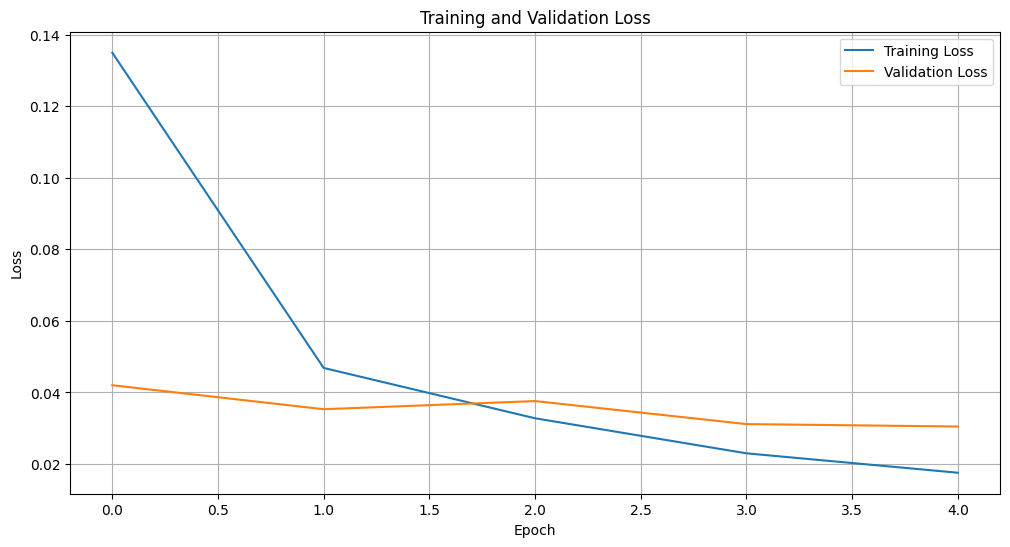

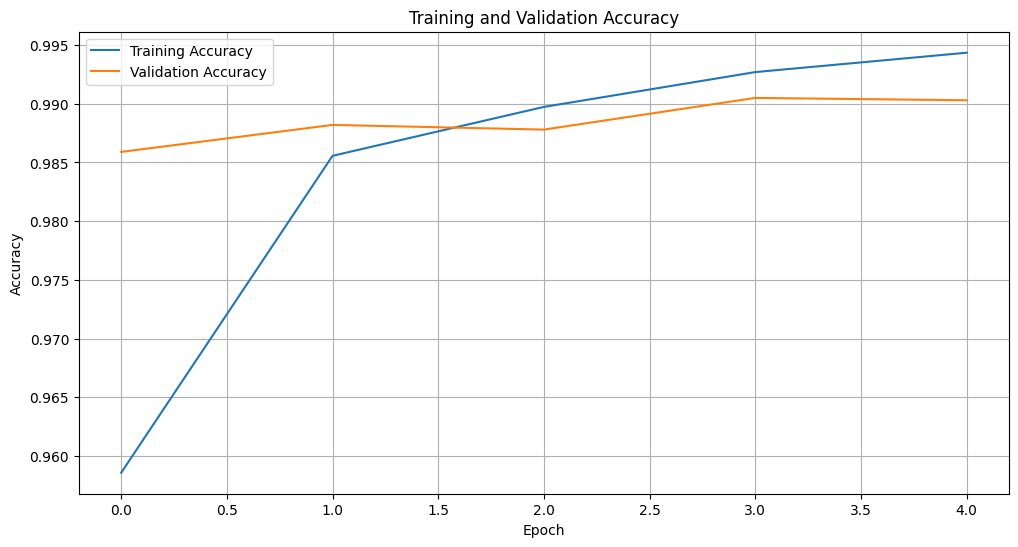

In [17]:
# 시각화
# 손실(Loss) 그래프
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 정확도(Accuracy) 그래프
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()